# Zernike circle polynomials
The [Zernike circle polynomials](https://en.wikipedia.org/wiki/Zernike_polynomials), $U^\ell_n(\varrho, \vartheta)$, are orthonormal polynomials inside a unitary circle, and low polynomials orders are related to the classical aberration distributions. 

The wavefront (aberration) distribution, $W(\varrho, \vartheta)$, tells how aberrated is the optical system and it is possible to decompose it in terms of a convenient set of polynomials, the Zernike circle polynomials,
$$ W(\varrho, \vartheta) = \sum_n\sum_\ell K_{n\ell} U^\ell_n(\varrho, \vartheta). $$
Where $K_{n\ell}$ are the Zernike circle polynomials coefficients. In general, if they're known it is possible to find the wavefront (aberration) distribution and how to correct or improve an optical system.

In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
# importing math and plot packages
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.constants import golden
from astropy.io import ascii
from astropy import units as u
from pyoof import zernike, cart2pol, aperture

Up to order $n=5$ there are $21$ Zernike circle polynomials, according to the rule $\frac{1}{2}(n+1)(n+2)$. The Zernike circle polynomials are subdivided in an angular and radial section. The radial section is known as radial polynomials, $R_n^\ell(\varrho)$. You can import the radial polynomials from the `zernike.R` module.

In [3]:
help(zernike.R)

Help on function R in module pyoof.zernike.zernike:

R(n, m, rho)
    Radial Zernike polynomials generator (:math:`R^m_n(\varrho)` from Born &
    Wolf definition). The :math:`m`, :math:`n` are integers, :math:`n\geqslant
    0` and :math:`n - m` even. Only used to compute the general expression for
    the Zernike circle polynomials, `~pyoof.zernike.U`.
    
    Parameters
    ----------
    n : `int`
        It is :math:`n \geqslant 0`. Order of the radial component.
    m : `int`
        Positive number, relative to the angle component.
    rho : `~numpy.ndarray`
        Values for the radial component, :math:`\varrho = \sqrt{x^2 + y^2}`.
    
    Returns
    -------
    radial_poly : `~numpy.ndarray`
        Radial Zernike polynomial already evaluated, :math:`R^m_n(\varrho)`.
    
    Notes
    -----
    The original generating formula for the radial polynomials is given by,
    
    .. math::
    
        R^{\pm m}_n (\varrho) = \frac{1}{\left(\frac{n-m}{2}\right)!
        \cdot \

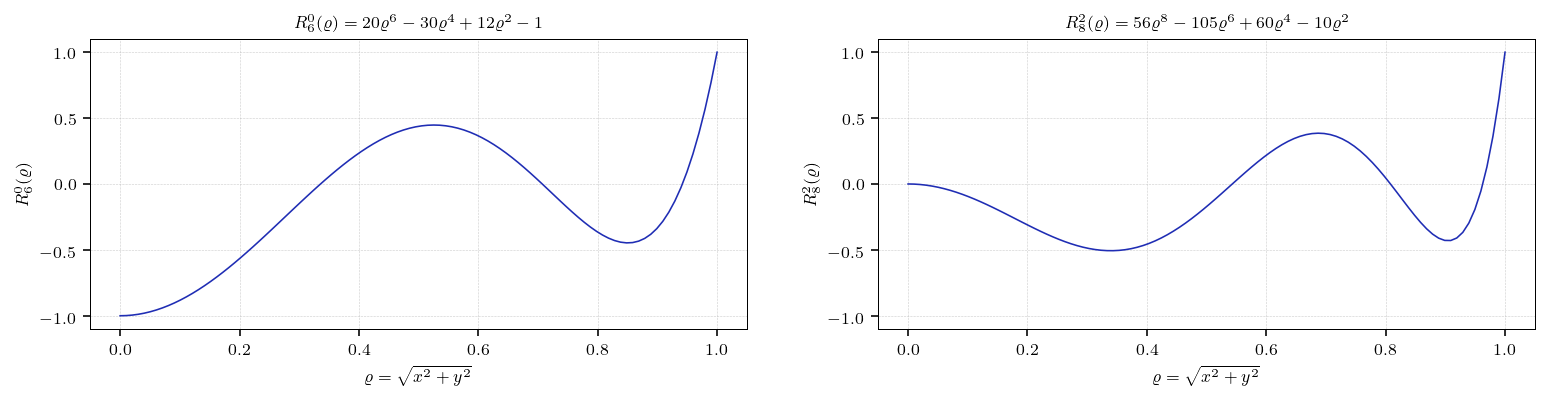

In [4]:
# Radial polynomials example
x_data = np.linspace(0, np.sqrt(.5), 100) * u.m
y_data = np.linspace(0, np.sqrt(.5), 100) * u.m
rho = np.sqrt(x_data ** 2 + y_data ** 2)

fig, ax = plt.subplots(ncols=2, figsize=(golden * 8, 8 / 3))

ax[0].plot(rho, zernike.R(n=6, m=0, rho=rho / rho.max()))
ax[1].plot(rho, zernike.R(n=8, m=2, rho=rho / rho.max()))
ax[0].set_title('$R^0_6(\\varrho)=20\\varrho^6-30\\varrho^4+12\\varrho^2-1$')
ax[0].set_ylabel('$R^0_6(\\varrho)$')
ax[1].set_title(
    '$R^2_8(\\varrho)=56\\varrho^8-105\\varrho^6+60\\varrho^4-10\\varrho^2$'
    )
ax[1].set_ylabel('$R^2_8(\\varrho)$')
for ax_ in ax:
    ax_.set_xlabel('$\\varrho=\sqrt{x^2+y^2}$')
    ax_.set_ylim(-1.1, 1.1)

Then depending on its angular value, the Zernike circle polynomials will differ, 

$$ U^{\ell}_n(\varrho, \vartheta) = R^{|\ell|}_n(\varrho, \vartheta)\cos|\ell|\vartheta \qquad \text{or} \qquad U^{\ell}_n(\varrho, \vartheta) = R^{|\ell|}_n(\varrho, \vartheta)\sin|\ell|\vartheta  $$

with $0\leq\ell$ or $\ell<0$, respectively. The module `zernike.U` has already loaded the raldia polynomials, then it is possible to compute several polynomials orders at a time.

In [5]:
help(zernike.U)

Help on function U in module pyoof.zernike.zernike:

U(n, l, rho, theta)
    Zernike circle polynomials generator (:math:`U^\ell_n(\varrho, \varphi)`
    from Born & Wolf definition). The :math:`\ell`, :math:`n` are integers,
    :math:`n \geqslant 0` and :math:`n - |\ell|` even. Expansion of a
    complete set of orthonormal polynomials in a unitary circle, specially
    useful when computing for the wavefront (aberration) distribution,
    :math:`W(x, y)`. The total number of polynomials is given by
    :math:`(n + 1)(n + 2) / 2.`
    
    Parameters
    ----------
    n : `int`
        It is :math:`n \geqslant 0`. Relative to radial component.
    l : `int`
        l Can be positive or negative, relative to angle component.
    rho : `~numpy.ndarray`
        Values for the radial component. :math:`\varrho = \sqrt{x^2 + y^2}`.
    theta : `~numpy.ndarray`
        Values for the angular component. For a rectangular grid x and y are
        evaluated as :math:`\vartheta = \mathrm{arcta

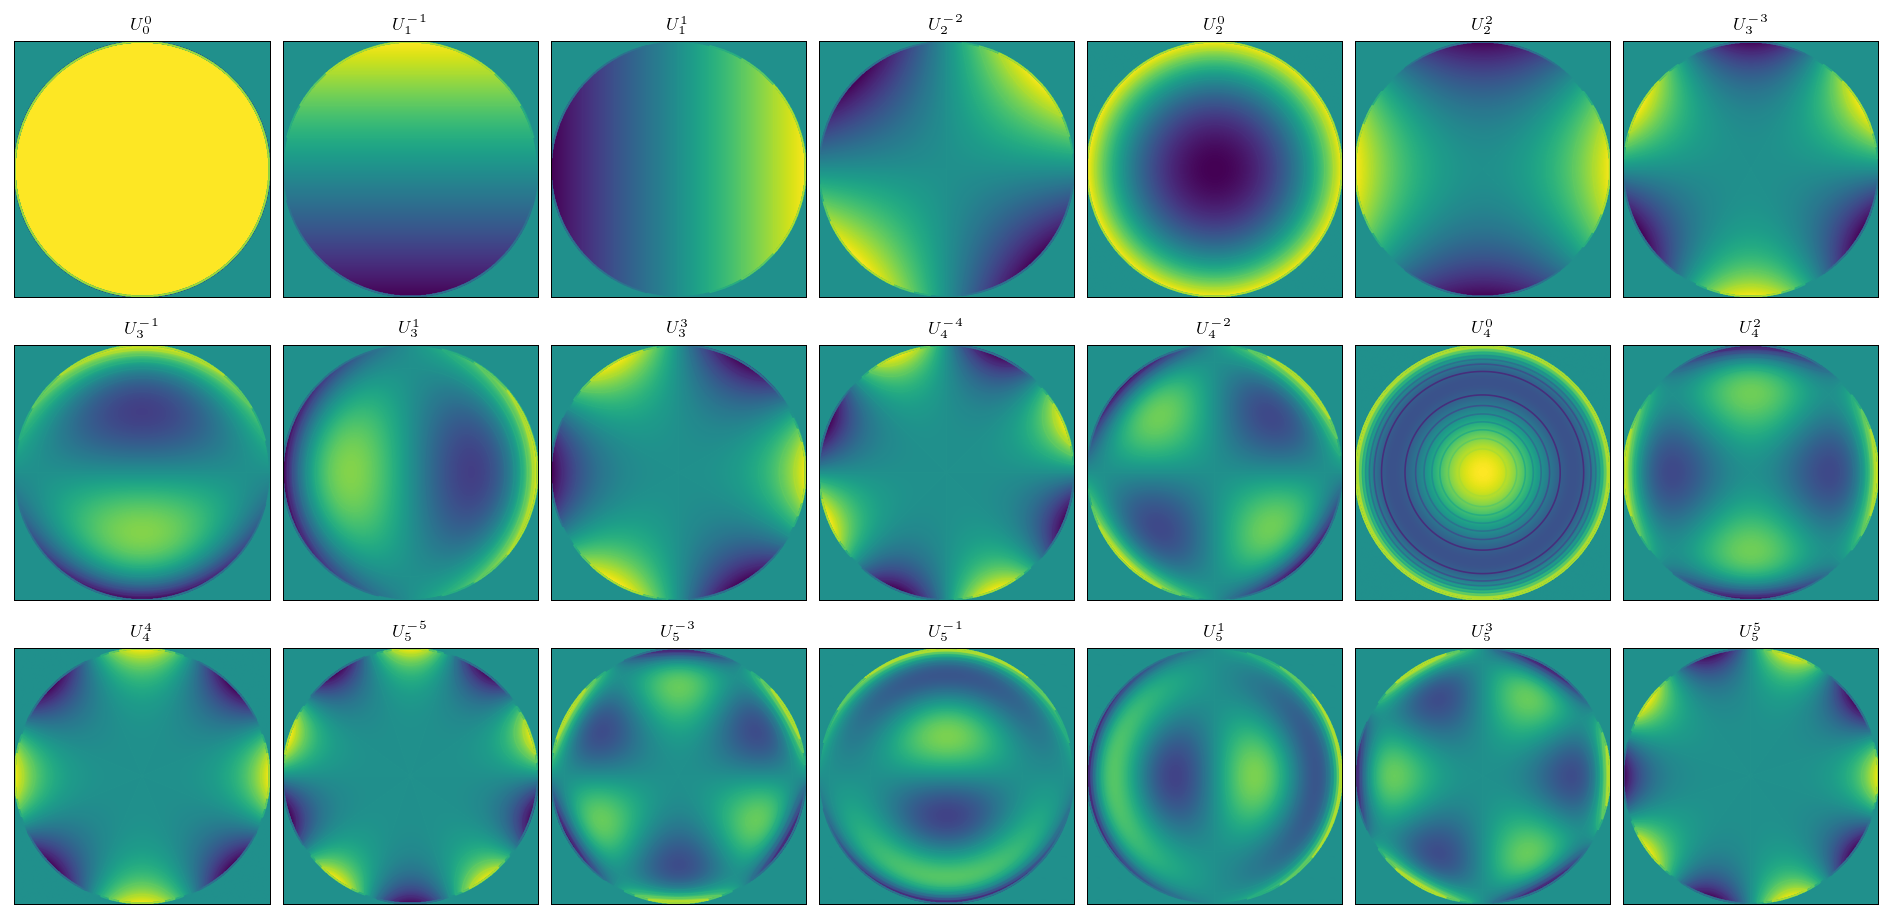

In [6]:
pr = 50 * u.m  # primary reflector radius
y_data = np.linspace(-pr, pr, 500)
x_data = np.linspace(-pr, pr, 500)
x_grid, y_grid = np.meshgrid(x_data, y_data)


# Zernike Pyramid
def circle(x, y, R=pr):
    circ = np.zeros(x.shape)  # or y.shape
    circ[x ** 2 + y ** 2 <= R ** 2] = 1
    return circ


circ = circle(x_grid, y_grid)
r, theta = cart2pol(x_grid, y_grid)
r_norm = r / pr

n_max = 5  # Max number n for the Zernike polynomials
nl = [(i, j) for i in range(0, n_max + 1) for j in range(-i, i + 1, 2)]
L = np.array(nl)[:, 1]
N = np.array(nl)[:, 0]
n_plots = len(L)

fig, axes = plt.subplots(nrows=3, ncols=7, figsize=(golden * 8, 7))
fig.subplots_adjust(left=0, bottom=0, right=1, top=.9, wspace=.05, hspace=.01)

ax = axes.flat
for i in range(n_plots):
    _U = zernike.U(*nl[i], r_norm, theta) * circ
    im = ax[i].imshow(_U, vmin=-1, vmax=1)

    contours = ax[i].contour(_U, 8)
    ax[i].set_title('$U^{' + str(L[i]) + '}_{' + str(N[i]) + '}$')
    ax[i].xaxis.set_major_formatter(plt.NullFormatter())
    ax[i].yaxis.set_major_formatter(plt.NullFormatter())
    ax[i].xaxis.set_ticks_position('none')
    ax[i].yaxis.set_ticks_position('none')
    ax[i].grid(False)

The wavefront (aberration) distribution can also be related to the aperture phase distribution, which tells the aberration of an optical system in radians of amplitude. It is given by,

$$ \varphi(x, y)=2\pi W(x, y) $$

The aperture phase distribution is measured without the tilt terms, in order to find the aberrations of an optical system. The tilt terms correspond to $U^{-1}_1(\varrho,\vartheta)$ and $U^{1}_1(\varrho, \vartheta)$. These polynomials are related to the telescope pointing and become irrelevant to the OOF holography analysis. Now follows an example of how to compute the aperture phase distribution.

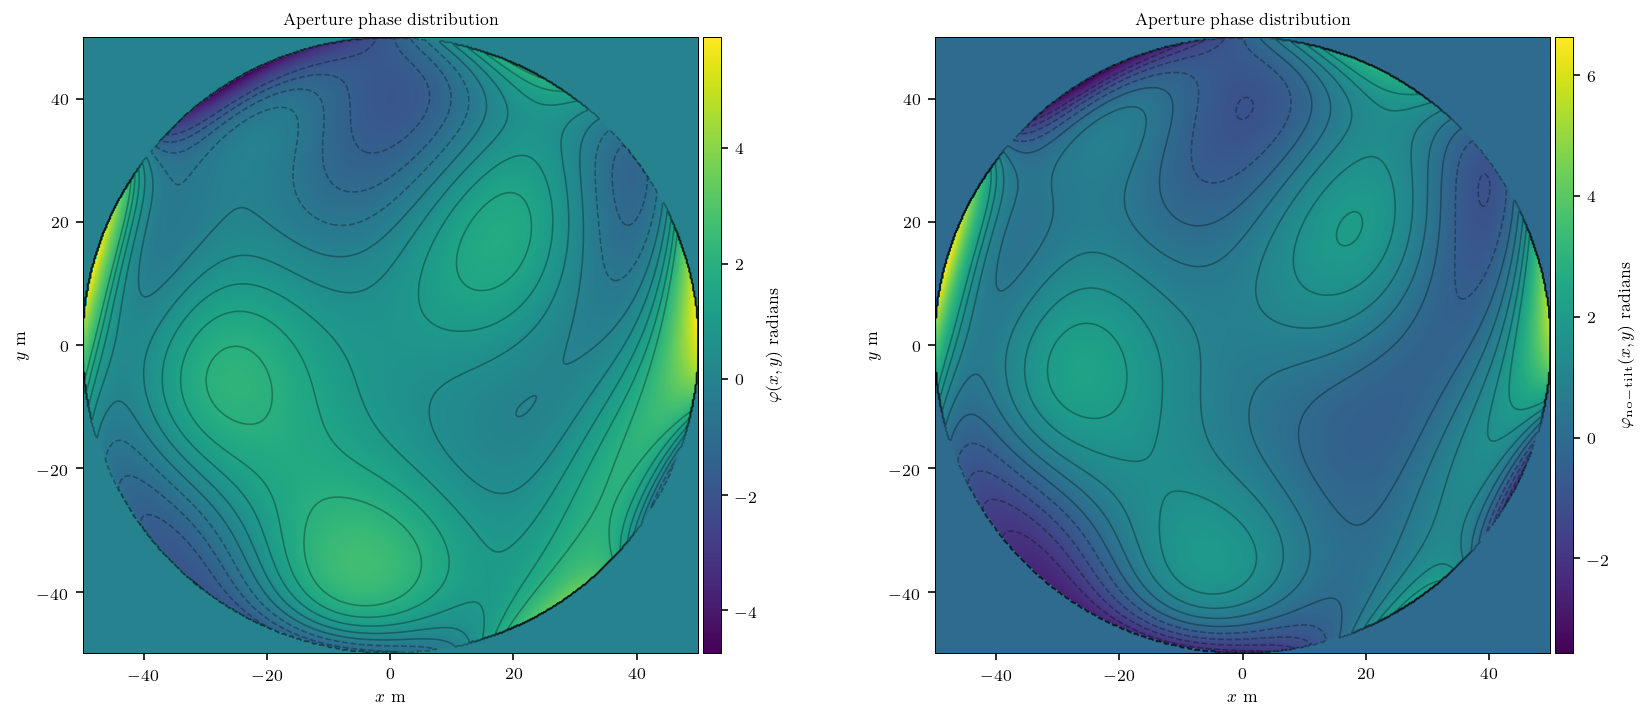

In [7]:
n = 7                               # order polynomial
N_K_coeff = (n + 1) * (n + 2) // 2  # max polynomial number
K_coeff = np.random.normal(0., .1, N_K_coeff)

# Wavefront (aberration) distribution -> phase error
W = aperture.wavefront(rho=r_norm, theta=theta, K_coeff=K_coeff)
phi = W * 2 * np.pi
phi[x_grid ** 2 + y_grid ** 2 > pr ** 2] = 0

K_coeff_notilt = K_coeff.copy()  # removing tilt terms
for i in range(1, 3):
    K_coeff_notilt[i] = 0

W_notitlt = aperture.wavefront(rho=r_norm, theta=theta, K_coeff=K_coeff_notilt)
phi_notilt = W_notitlt * 2 * np.pi
phi_notilt[x_grid ** 2 + y_grid ** 2 > pr ** 2] = 0

extent = [-pr.to_value(u.m), pr.to_value(u.m)] * 2
levels = np.linspace(-2, 2, 9)  # half-radian increase
cbtitle = ['$\\varphi(x, y)$ radians', '$\\varphi_\mathrm{no-tilt}(x, y)$ radians']

fig, ax = plt.subplots(figsize=(14, 7 * golden / 2), ncols=2)

for i, _phi, _cbtitle in zip(range(2), [phi, phi_notilt], cbtitle):
    
    im = ax[i].imshow(_phi, extent=extent)
    ax[i].contour(x_grid, y_grid, _phi, levels=levels, colors='k', alpha=0.3)
    ax[i].set_title('Aperture phase distribution')

    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="3%", pad=0.03)
    cb = fig.colorbar(im, cax=cax)
    cb.ax.set_ylabel(_cbtitle)

    ax[i].grid(False)
    ax[i].set_xlabel('$x$ m')
    ax[i].set_ylabel('$y$ m')

The phase error amplitude is measured in radians. 